In [93]:
# coding: utf-8
"""
    captcha.image
    ~~~~~~~~~~~~~

    Generate Image CAPTCHAs, just the normal image CAPTCHAs you are using.
"""

import os
import random
from PIL import ImageOps 
from PIL import Image
from PIL import ImageFilter
from PIL.ImageDraw import Draw
from PIL.ImageFont import truetype
try:
    from cStringIO import StringIO as BytesIO
except ImportError:
    from io import BytesIO
try:
    from wheezy.captcha import image as wheezy_captcha
except ImportError:
    wheezy_captcha = None

DATA_DIR = 'captcha-master/captcha/data'
DEFAULT_FONTS = [os.path.join(DATA_DIR, 'DroidSansMono.ttf')]

In [726]:
if wheezy_captcha:
    __all__ = ['ImageCaptcha', 'WheezyCaptcha']
else:
    __all__ = ['ImageCaptcha']


table  =  []
for  i  in  range( 256 ):
    table.append( i * 1.97 )


class _Captcha(object):
    def generate(self, chars, format='png'):
        """Generate an Image Captcha of the given characters.

        :param chars: text to be generated.
        :param format: image file format
        """
        im = self.generate_image(chars)
        out = BytesIO()
        im.save(out, format=format)
        out.seek(0)
        return out

    def write(self, chars, output, format='png'):
        """Generate and write an image CAPTCHA data to the output.

        :param chars: text to be generated.
        :param output: output destination.
        :param format: image file format
        """
        im = self.generate_image(chars)
        return im.save(output, format=format)


class WheezyCaptcha(_Captcha):
    """Create an image CAPTCHA with wheezy.captcha."""
    def __init__(self, width=200, height=75, fonts=None):
        self._width = width
        self._height = height
        self._fonts = fonts or DEFAULT_FONTS

    def generate_image(self, chars):
        text_drawings = [
            wheezy_captcha.warp(),
            wheezy_captcha.rotate(),
            wheezy_captcha.offset(),
        ]
        fn = wheezy_captcha.captcha(
            drawings=[
                wheezy_captcha.background(),
                wheezy_captcha.text(fonts=self._fonts, drawings=text_drawings),
                wheezy_captcha.curve(),
                wheezy_captcha.noise(),
                wheezy_captcha.smooth(),
            ],
            width=self._width,
            height=self._height,
        )
        return fn(chars)


class ImageCaptcha(_Captcha):
    """Create an image CAPTCHA.

    Many of the codes are borrowed from wheezy.captcha, with a modification
    for memory and developer friendly.

    ImageCaptcha has one built-in font, DroidSansMono, which is licensed under
    Apache License 2. You should always use your own fonts::

        captcha = ImageCaptcha(fonts=['/path/to/A.ttf', '/path/to/B.ttf'])

    You can put as many fonts as you like. But be aware of your memory, all of
    the fonts are loaded into your memory, so keep them a lot, but not too
    many.

    :param width: The width of the CAPTCHA image.
    :param height: The height of the CAPTCHA image.
    :param fonts: Fonts to be used to generate CAPTCHA images.
    :param font_sizes: Random choose a font size from this parameters.
    """
    def __init__(self, width=160, height=60, fonts=None, font_sizes=None):
        self._width = width
        self._height = height
        self._fonts = fonts or DEFAULT_FONTS
        self._font_sizes = font_sizes or (42, 50, 56)
        self._truefonts = []

    @property
    def truefonts(self):
        if self._truefonts:
            return self._truefonts
        self._truefonts = tuple([
            truetype(n, s)
            for n in self._fonts
            for s in self._font_sizes
        ])
        return self._truefonts

    @staticmethod
    def create_noise_curve(image, color):
        w, h = image.size
        x1 = random.randint(0, int(w/5))
        x2 = random.randint(int(w/5), w)
        y1 = random.randint(0, int(h / 2))
        y2 = random.randint(y1, h)
        points = [x1, y1, x2, y2]
        end = random.randint(160, 200)
        start = random.randint(0, 20)
        Draw(image).arc(points, start, end, fill=color)
        return image

    @staticmethod
    def create_noise_dots(image, color, width=3, number=30):
        draw = Draw(image)
        w, h = image.size
        while number:
            x1 = random.randint(0, w)
            y1 = random.randint(0, h)
            draw.line(((x1, y1), (x1 - 1, y1 - 1)), fill=color, width=width)
            number -= 1
        return image

    def create_captcha_image(self, chars, color, background):
        """Create the CAPTCHA image itself.

        :param chars: text to be generated.
        :param color: color of the text.
        :param background: color of the background.

        The color should be a tuple of 3 numbers, such as (0, 255, 255).
        """
        image = Image.new('RGB', (self._width, self._height), background)
        draw = Draw(image)

        def _draw_character(c):
            font = random.choice(self.truefonts)
            w, h = draw.textsize(c, font=font)

            dx = random.randint(0, 4)
            dy = random.randint(0, 1)
            im = Image.new('RGBA', (w + dx, h + dy))
            Draw(im).text((dx, dy), c, font=font, fill=color)

            # rotate
            im = im.crop(im.getbbox())
            #im = im.rotate(random.uniform(-30, 30), Image.BILINEAR, expand=1)

            # warp
            dx = 0
            dy = 0
            x1 = int(random.uniform(-dx, dx))
            y1 = int(random.uniform(-dy, dy))
            x2 = int(random.uniform(-dx, dx))
            y2 = int(random.uniform(-dy, dy))
            w2 = w + abs(x1) + abs(x2)
            h2 = h + abs(y1) + abs(y2)
            data = (
                x1, y1,
                -x1, h2 - y2,
                w2 + x2, h2 + y2,
                w2 - x2, -y1,
            )
            im = im.resize((w2, h2))
            im = im.transform((w, h), Image.QUAD, data)
            return im

        images = []
        for c in chars:
#             if random.random() > 0.5:
#                 images.append(_draw_character(" "))
            images.append(_draw_character(c))

        text_width = sum([im.size[0] for im in images])

        width = max(text_width, self._width)
        image = image.resize((width, self._height))

        average = int(text_width / len(chars))
        rand = int(0.25 * average)
        offset = int(average * 1.5)

        for im in images:
            w, h = im.size
            mask = im.convert('L').point(table)
            image.paste(im, (offset, int((self._height - h) / 2)), mask)
            offset = offset + w + random.randint(-rand, 0)

        if width > self._width:
            image = image.resize((self._width, self._height))

        return image

    def generate_image(self, chars):
        """Generate the image of the given characters.

        :param chars: text to be generated.
        """
        background = random_color(50, 50, 255)
        color = random_color(255,255, 255)
        im = self.create_captcha_image(chars, color, background)
        # self.create_noise_dots(im, color)
        self.create_noise_curve(im, color)
        self.create_noise_curve(im, color)
        im = im.filter(ImageFilter.SMOOTH)
        im = ImageOps.invert(im)
        return im


def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (red, green, blue)
    return (red, green, blue, opacity)

In [12]:
number = ['0','1','2','3','4','5','6','7','8','9']
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

MAX_CAPTCHA = 5

WIDTH=160
HEIGHT=60


def get_char_set():
	return number#+alphabet

def get_char_set_len():
	return len(get_char_set())

def get_captcha_size():
	return MAX_CAPTCHA

def get_y_len():
	return MAX_CAPTCHA*get_char_set_len()

def get_width():
    return WIDTH

def get_height():
    return HEIGHT

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

height_p = 60
width_p = 160

In [14]:
# generate  the captcha text randomly from the char lists above
def random_captcha_text(char_set = get_char_set(), captcha_size = get_captcha_size()):
	captcha_text = []
	for i in range(captcha_size):
		c = random.choice(char_set)
		captcha_text.append(c)
	return captcha_text

In [22]:
# generate the captcha text and image and save the image 
def gen_captcha_text_and_image(i):
	image = ImageCaptcha(width=160, height=60, font_sizes=[30])
 
	captcha_text = random_captcha_text()
	captcha_text = ''.join(captcha_text)

	path = './data/'
	if os.path.exists(path) == False: # if the folder is not existed, create it
		os.mkdir(path)
                
	captcha = image.generate(captcha_text)

	# naming rules: num(in order)+'_'+'captcha text'.include num is for avoiding the same name
	image.write(captcha_text, path+str(i)+'_'+captcha_text + '.png') 
 
	captcha_image = Image.open(captcha)
	captcha_image = np.array(captcha_image)
	return captcha_text, captcha_image
 
if __name__ == '__main__':

        
        for i in range(24000):     
                text, image = gen_captcha_text_and_image(i)

        # show the image
        '''
	f = plt.figure()
	ax = f.add_subplot(111)
	ax.text(0.1, 0.9,text, ha='center', va='center', transform=ax.transAxes)
	plt.imshow(image)
 
	plt.show()
        '''

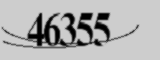

In [733]:
image = ImageCaptcha(width=160, height=60, fonts=['7676.ttf'], font_sizes=[36])
captcha = image.generate(random_captcha_text())
captcha_image = Image.open(captcha)
captcha_image

In [68]:
print(type(captcha_image))

<class 'PIL.PngImagePlugin.PngImageFile'>


In [24]:
random_captcha_text()

['4', '5', '4', '7', '5']

## Обучение

In [180]:
# LOAD_DATA
# Author:kemo

import os
from PIL import Image
import numpy as np
import random

np.random.seed(1337)

# load_data.py and captcha_recognition.py we need to define the MAX_CAPTCHA,the CHAR_SET_LEN ,the tol_num,the train_num and the parameters of the model

# the length of the captcha text
MAX_CAPTCHA = get_captcha_size()
# the number of elements in the char set 
CHAR_SET_LEN = get_char_set_len()

CHAR_SET = get_char_set()

Y_LEN = get_y_len()

height = get_height()
width = get_width()

# return the index of the max_num in the array
def get_max(array):
    max_num = max(array)
    for i in range(len(array)):
        if array[i] == max_num:
            return i

def get_text(array):
    text = []
    max_num = max(array)
    for i in range(len(array)):
        text.append(CHAR_SET[array[i]])
    return text

# text to vector.For example, if the char set is 1 to 10,and the MAX_CAPTCHA is 1
# text2vec(1) will return [0,1,0,0,0,0,0,0,0,0]
def text2vec(text):
    text_len = len(text)
    if text_len > MAX_CAPTCHA:
        raise ValueError(MAX_CAPTCHA)
        # the shape of the vector is 1*(MAX_CAPTCHA*CHAR_SET_LEN)
    vector = np.zeros(MAX_CAPTCHA*CHAR_SET_LEN)
    def char2pos(c):
        k = CHAR_SET.index(c)
        return k
    for i, c in enumerate(text):
        idx = i * CHAR_SET_LEN + char2pos(c)
        vector[idx] = 1
    return vector


# text to vector.For example, if the char set is 1 to 10,and the MAX_CAPTCHA is 1
# text2vec(1) will return [0,1,0,0,0,0,0,0,0,0]
def text2vec2(text):
    text_len = len(text)
    if text_len > MAX_CAPTCHA:
        raise ValueError('max4')
        # the shape of the vector is 1*(MAX_CAPTCHA*CHAR_SET_LEN)
    vector = np.zeros(MAX_CAPTCHA)
    def char2pos(c):
        k = 30
        return k
    for i, c in enumerate(text):
        idx = i
        vector[idx] = char2pos(c)
    return vector

def load_data(tol_num,train_num):
      
    # input,tol_num: the numbers of all samples(train and test)
    # input,train_num: the numbers of training samples
    # output,(X_train,y_train):trainging data
    # ouput,(X_test,y_test):test data
 
    data = np.empty((tol_num, 1, height, width),dtype="float32")
    label = np.empty((tol_num,Y_LEN),dtype="uint8")

    # data dir
    imgs = os.listdir("data")
    
    for i in range(tol_num):
        # load the images and convert them into gray images
        img = get_image_from_file("data/"+imgs[i])

        arr = np.asarray(img,dtype="float32")
        try:
            data[i,:,:,:] = arr
            captcha_text = imgs[i].split('.')[0].split('_')[1]
            label[i]= text2vec(captcha_text)
        except:
            pass

    # the data, shuffled and split between train and test sets
    rr = [i for i in range(tol_num)] 
    random.shuffle(rr)
    X_train = data[rr][:train_num]
    y_train = label[rr][:train_num]
    X_test = data[rr][train_num:]
    y_test = label[rr][train_num:]
    
    return (X_train,y_train),(X_test,y_test)

def get_image_from_file(path_img):
    img = Image.open(path_img)
    return pre_process_image(img)

def load_image(img):
    tol_num = 1
    data = np.empty((tol_num, 1, height, width),dtype="float32")

    img = pre_process_image(img)

    arr = np.asarray(img,dtype="float32")
    data[0,:,:,:] = arr
    return data


def pre_process_image(img):
    img = img.convert('L')
    # Resize it.
    img = img.resize((width, height), Image.BILINEAR)

    return img


def get_x_input_from_file(img):
    with open(fileName, mode='rb') as file: # b is important -> binary
        fileContent = file.read()

    stream = io.BytesIO(r_data)

    img = Image.open(stream)

    X_test = get_x_input_from_image(img)

    return X_test

def get_x_input_from_image(img):
    X_test = load_image(img)

    X_test = X_test.reshape(X_test.shape[0], height, width, 1)

    X_test = X_test.astype('float32')
    X_test /= 255

    return X_test

In [26]:
# LOAD_MODEL
import os.path
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import model_from_json


MAX_CAPTCHA = get_captcha_size()
CHAR_SET_LEN = get_char_set_len()

# number of convolutional filters to use
nb_filters1 = 32
nb_filters2 = 64
nb_filters3 = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

WEIGHT_FILE = "my_model_weights.h5"

def get_model(input_shape):
    model = Sequential()
    if os.path.exists(WEIGHT_FILE):
        print ("loading the trained model")
        model = model_from_json(open('my_model.json').read())  
        model.load_weights(WEIGHT_FILE)

    else:
        # 3 conv layer
        model.add(Conv2D(nb_filters1, (kernel_size[0], kernel_size[1]), padding='valid', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))

        model.add(Conv2D(nb_filters2, (kernel_size[0], kernel_size[1])))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))

        model.add(Conv2D(nb_filters3, (kernel_size[0], kernel_size[1])))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))

        # Fully connected layer
        model.add(Flatten())
        model.add(Dense(1024*MAX_CAPTCHA))
        model.add(Dense(512*MAX_CAPTCHA))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Dense(MAX_CAPTCHA*CHAR_SET_LEN))
        model.add(Activation('softmax'))
        
    json_string = model.to_json()
    open("my_model.json","w").write(json_string)
    return model


def get_weights_file():
    return WEIGHT_FILE

In [27]:
'''
Author:kemo

Trains a captcha datasets, each captcha includes four number.
Gets to 63.9% test accuracy after 64 epochs
(there is still a lot of margin for parameter tuning).
120 seconds per epoch on a Nvidia GeForce 940M GPU.
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.utils import np_utils
from keras import backend as K
import h5py
from keras.callbacks import ModelCheckpoint

In [28]:
#!pip install tensorflow

In [186]:
# input image dimensions
img_rows, img_cols = get_height(), get_width()

batch_size = 128
nb_epoch = 32

MAX_CAPTCHA = get_captcha_size()
CHAR_SET_LEN = get_char_set_len()



# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = load_data(tol_num = 3000,train_num = 2500)

# i use the theano backend
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

model = get_model(input_shape)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

filepath = get_weights_file()
#es = Earl
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test,Y_test), callbacks=callbacks_list)

score = model.evaluate(X_test, Y_test, verbose=0)
predict = model.predict(X_test,batch_size = batch_size,verbose = 0)

# calculate the accuracy with the test data
acc = 0
for i in range(X_test.shape[0]):
    true = []
    predict2 = []
    for j in range(MAX_CAPTCHA):
        true.append(get_max(Y_test[i,CHAR_SET_LEN*j:(j+1)*CHAR_SET_LEN]))
        predict2.append(get_max(predict[i,CHAR_SET_LEN*j:(j+1)*CHAR_SET_LEN]))
    if true == predict2:
        acc+=1
    if i<20:
        print (i,' true: ',true)
        print (i,' predict: ',predict2)
print('predict correctly: ',acc)
print('total prediction: ',X_test.shape[0])
print('Score: ',score)

X_train shape: (2500, 60, 160, 1)
2500 train samples
500 test samples
Train on 2500 samples, validate on 500 samples
Epoch 1/32
2500/2500 [==============================] - 24s 10ms/step - loss: 19.7981 - acc: 0.0144 - val_loss: 19.5593 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to my_model_weights.h5
Epoch 2/32
2500/2500 [==============================] - 22s 9ms/step - loss: 19.5608 - acc: 0.0016 - val_loss: 19.5609 - val_acc: 0.1100

Epoch 00002: val_acc improved from 0.00000 to 0.11000, saving model to my_model_weights.h5
Epoch 3/32
2500/2500 [==============================] - 22s 9ms/step - loss: 19.5602 - acc: 0.0304 - val_loss: 19.5590 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.11000
Epoch 4/32
2500/2500 [==============================] - 23s 9ms/step - loss: 19.5609 - acc: 0.0036 - val_loss: 19.5601 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.11000
Epoch 5/32
2500/2500 [=================

In [191]:
image_for_pred = Image.open('./data/10759_94183.png')
type(image_for_pred)

PIL.PngImagePlugin.PngImageFile

In [192]:
captchaEval = CaptchaEval()
text = captchaEval.predict_from_img(image_for_pred)
print (text)

loading the trained model
94288


In [189]:
image_for_pred = Image.open('./data/4519_21559.png')
type(image_for_pred)

PIL.PngImagePlugin.PngImageFile

In [190]:
captchaEval = CaptchaEval()
text = captchaEval.predict_from_img(image_for_pred)
print (text)

loading the trained model
11509


### Загрузка изображений из Росреестра

In [31]:
import requests as req
from bs4 import BeautifulSoup

In [33]:
url = 'https://rosreestr.ru/wps/portal/online_request'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2224.3 Safari/537.36'}
page = req.get(url, headers = headers)
print(page.content)

b'<!DOCTYPE html>\n<html lang="ru" xml:lang="ru">\n<head>\n\t<!--<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1, minimum-scale=1"/>-->\n\t<meta name="google-site-verification" content="rVxCzUlW0G3ecSPGtVqlLM5AtY-yfSoX5n8DCA4pdcE"/>\n\t<link rel="stylesheet" href="/wps/contenthandler/!ut/p/digest!i7j42wVIH2kObPvgdhUqKA/sp/mashup:ra:collection?themeID=ZJ_GQ4E1C41KOMJ20AIOTDK0F3085&amp;locale=en&amp;mime-type=text%2Fcss&amp;entry=wp_one_ui_30__0.0%3Ahead_css&amp;entry=wp_one_ui_dijit_30__0.0%3Ahead_css&amp;entry=wp_status_bar__0.0%3Ahead_css&amp;entry=wp_portlet_css__0.0%3Ahead_css&amp;entry=wp_theme_portal_80__0.0%3Ahead_css&amp;entry=wp_legacy_layouts__0.0%3Ahead_css&amp;entry=wp_project_menu__0.0%3Ahead_css&amp;entry=wp_ic4_wai_resources__0.0%3Ahead_css&amp;entry=wp_preview__0.0%3Ahead_css&amp;entry=wp_oob_sample_styles__0.0%3Ahead_css" type="text/css"/><link rel="alternate" id="head_css_deferred" href="/wps/contenthandler/!ut/p/digest!D60zoVlAaCtfI

In [34]:
soup = BeautifulSoup(page.text,'html.parser')
soup.html.head.title

<title>Справочная информация по объектам недвижимости в режиме online - Портал услуг Федеральной службы государственной регистрации, кадастра и картографии</title>

In [35]:
soup.find("img", attrs={ "id" : "captchaImage2"})
#soup.findAll(lambda tag: tag.get('id') == ['captchaImage2'])

<img id="captchaImage2" src="p0/IZ7_01HA1A42KODT90AR30VLN22001=CZ6_GQ4E1C41KGQ170AIAK131G00T5=NJcaptcha=/"/>

In [80]:
import PIL
from PIL import Image as IM
from io import BytesIO
import cv2
import numpy as np
import io
from IPython.display import display,Image,clear_output
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils

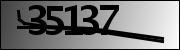

In [725]:
response = req.get('https://rosreestr.ru/wps/portal/p/cc_ib_portal_services/online_request/!ut/p/z1/04_Sj9CPykssy0xPLMnMz0vMAfIjo8zi3QNNXA2dTQy93QMNzQ0cPR29DY0N3Q0MQkz1w_Eq8DfUj6JEP1ABSL8BDuBoANQfhdcKZyMCCkBOJGRJQW5ohEGmpyIAKLXudw!!/p0/IZ7_01HA1A42KODT90AR30VLN22001=CZ6_GQ4E1C41KGQ170AIAK131G00T5=NJcaptcha=/')
captcha_byte = io.BytesIO(response.content)
image = PIL.Image.open(captcha_byte)
img_2 = np.copy(IM.open(BytesIO(response.content)))
img_2.shape
image

In [116]:
image_for_pred = Image.open(captcha_byte)
type(image_for_pred)

PIL.PngImagePlugin.PngImageFile

In [123]:
image_for_pred.save('./rosreestr_captcha/55946.jpg')

### Проверка модели

In [42]:
class CaptchaEval:

	def __init__(self):
		# load the trained model
		self.model = get_model('')

		self.model.compile(loss='categorical_crossentropy',
		              optimizer='adadelta',
		              metrics=['accuracy'])

   
	def predict_from_img(self, img):
		X_test = get_x_input_from_image(img)


		predict = self.model.predict(X_test)


		text = ''
		for i in range(X_test.shape[0]):
		    true = []
		    predict2 = []
		    for j in range(get_captcha_size()):
		        char_index = get_max(predict[i,get_char_set_len()*j:(j+1)*get_char_set_len()])
		        char = get_char_set()[char_index]
		        predict2.append(char)
		    text = text.join(predict2)

		return text

In [117]:
captchaEval = CaptchaEval()
text = captchaEval.predict_from_img(image_for_pred)
print (text)

loading the trained model
24542


## Дообучение модели

In [127]:
import time

In [128]:
for i in range(250):
    response = req.get('https://rosreestr.ru/wps/portal/p/cc_ib_portal_services/online_request/!ut/p/z1/04_Sj9CPykssy0xPLMnMz0vMAfIjo8zi3QNNXA2dTQy93QMNzQ0cPR29DY0N3Q0MQkz1w_Eq8DfUj6JEP1ABSL8BDuBoANQfhdcKZyMCCkBOJGRJQW5ohEGmpyIAKLXudw!!/p0/IZ7_01HA1A42KODT90AR30VLN22001=CZ6_GQ4E1C41KGQ170AIAK131G00T5=NJcaptcha=/')
    time.sleep(1)
    captcha_byte = io.BytesIO(response.content)
    image_for_pred = Image.open(captcha_byte)
    image_for_pred.save('./rosreestr_captcha/' + str(i) + '.jpg')

In [137]:
# input image dimensions
img_rows, img_cols = get_height(), get_width()

batch_size = 128
nb_epoch = 16

MAX_CAPTCHA = get_captcha_size()
CHAR_SET_LEN = get_char_set_len()

# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = load_data(tol_num = 200,train_num = 198)

# i use the theano backend
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

model = get_model(input_shape)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

filepath = get_weights_file()
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test,Y_test), callbacks=callbacks_list)

score = model.evaluate(X_test, Y_test, verbose=0)
predict = model.predict(X_test,batch_size = batch_size,verbose = 0)

# calculate the accuracy with the test data
acc = 0
for i in range(X_test.shape[0]):
    true = []
    predict2 = []
    for j in range(MAX_CAPTCHA):
        true.append(get_max(Y_test[i,CHAR_SET_LEN*j:(j+1)*CHAR_SET_LEN]))
        predict2.append(get_max(predict[i,CHAR_SET_LEN*j:(j+1)*CHAR_SET_LEN]))
    if true == predict2:
        acc+=1
    if i<20:
        print (i,' true: ',true)
        print (i,' predict: ',predict2)
print('predict correctly: ',acc)
print('total prediction: ',X_test.shape[0])
print('Score: ',score)

X_train shape: (198, 60, 160, 1)
198 train samples
2 test samples
Train on 198 samples, validate on 2 samples
Epoch 1/16
198/198 [==============================] - 4s 20ms/step - loss: 19.7555 - acc: 0.0404 - val_loss: 19.7586 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to my_model_weights.h5
Epoch 2/16
198/198 [==============================] - 2s 10ms/step - loss: 19.4728 - acc: 0.0000e+00 - val_loss: 19.3821 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/16
198/198 [==============================] - 2s 9ms/step - loss: 19.2066 - acc: 0.0051 - val_loss: 19.2942 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/16
198/198 [==============================] - 2s 10ms/step - loss: 19.1847 - acc: 0.0253 - val_loss: 19.3382 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/16
198/198 [==============================] - 2s 10ms/step - loss: 19.1326 - acc:

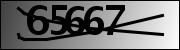

In [177]:
response = req.get('https://rosreestr.ru/wps/portal/p/cc_ib_portal_services/online_request/!ut/p/z1/04_Sj9CPykssy0xPLMnMz0vMAfIjo8zi3QNNXA2dTQy93QMNzQ0cPR29DY0N3Q0MQkz1w_Eq8DfUj6JEP1ABSL8BDuBoANQfhdcKZyMCCkBOJGRJQW5ohEGmpyIAKLXudw!!/p0/IZ7_01HA1A42KODT90AR30VLN22001=CZ6_GQ4E1C41KGQ170AIAK131G00T5=NJcaptcha=/')
captcha_byte = io.BytesIO(response.content)
image = PIL.Image.open(captcha_byte)
img_2 = np.copy(IM.open(BytesIO(response.content)))
img_2.shape
image

In [178]:
image_for_pred = Image.open(captcha_byte)
type(image_for_pred)

PIL.PngImagePlugin.PngImageFile

In [179]:
captchaEval = CaptchaEval()
text = captchaEval.predict_from_img(image_for_pred)
print (text)

loading the trained model
31845
